# INM701: $k$-Nearest Neighbours

We use scikit-learn to train and test a $k$-nearest neighbours model on a dataset of proteins and their secondary structures.

The work presented here is part of the coursework of the INM701 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM701).

### Import Libraries

In [1]:
# Import Relevant Libraries
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Ignore warnings (making the work easier to read)
import warnings
warnings.filterwarnings("ignore")

### Import Dataset

Refer to the 'eda-data-processing.ipynb' workbook for more detail on how this dataset was created.

In [2]:
# Create a variable for the path to the directory containing the dataset (and where to work)
path = "/kaggle/input/protein-sequences-16-100"

# Create a variable containing the full path of the dataset
dataset = os.path.join(path, "prot-seq-filtered.csv")

# Create a Pandas DataFrame of the dataset (which is a .csv file)
df = pd.read_csv(dataset, delimiter = ",")

df

,pdb_id,chain_code,seq,sst8,sst3,len
0,1BXL,B,GQVGRQLAIIGDDINR,CCTTHHHHHHHHHTCC,CCCCHHHHHHHHHCCC,16
1,1D9K,P,GNSHRGAIEWEGIESG,CCEECCCCCCCCCCCC,CCEECCCCCCCCCCCC,16
2,1DPU,B,RIQRNKAAALLRLAAR,CCSSHHHHHHHHHHCC,CCCCHHHHHHHHHHCC,16
3,1DXP,C,KGSVVIVGRIILSGRK,CCCBEEEEEEEECCCC,CCCEEEEEEEEECCCC,16
4,1EJH,E,KQYDREFLLDFQFMPA,CCCCHHHHHTTSCCCC,CCCCHHHHHCCCCCCC,16
...,...,...,...,...,...,...
15267,6UUJ,A,GAMVPEGLAAASAAVEALTARLAAAHASAAPVITAVVPPAADPVSL...,CCCCCSTTHHHHHHHHHHHHHHHHHHHHSHHHHHSCCCSSSSHHHH...,CCCCCCCCHHHHHHHHHHHHHHHHHHHHCHHHHHCCCCCCCCHHHH...,100
15268,6V7M,A,MKVLWAALLVTFLAGCQAKVEQAVETEPEPELRQQTEWQSGQRWEL...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHH...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCHHHH...,100
15269,6VQX,A,MKVPAFFAANILTIEQIIEAINNDGSAMTSAPEIAGYYAWDAATDA...,CCCCSSTTSSCCCHHHHHHHHHTTSCTTSCHHHHHHHHHHHHHHHS...,CCCCCCCCCCCCCHHHHHHHHHCCCCCCCCHHHHHHHHHHHHHHHC...,100
15270,6XVF,F,RWLEGIRKWYYNAAGFNKLGLMRDDTIHENDDVKEAIRRLPENLYN...,CCTHHHHHHHHHHHCGGGGTCCGGGSBCCCHHHHHHHHTSCHHHHH...,CCCHHHHHHHHHHHCHHHHCCCHHHCECCCHHHHHHHHCCCHHHHH...,100


### Set Random Seed and $k$-mer Size

We choose a seed for reproducibility and a sensible $k$-mer size.

In [3]:
# k-mer size and seed choice

kmer_size = 3
randomer = 50

# Random Seed
random.seed(randomer)
np.random.seed(randomer)

### Generate $k$-mers

We convert our protein sequences in to $k$-mers, making the problem less computationally expensive. The choice of $k$ affects the performance of the model, with higher $k$ likely leading to less accurate models. This accuracy can vary based on much larger datasets, and with longer protein sequences.

For example, the 3-mers for "GQVGRQ" are:

GQV, QVG, VGR, GRQ

In [4]:
# Define k-mer function (n-gram)
def kmers(seq, k = kmer_size):
    return ([seq[i:i + k] for i in range(len(seq) - k + 1)])

# Apply the k-mer function to the amino acid sequences
df["kmers"] = df["seq"].apply(kmers)

# Find the maximum length of the sequences (we know from previously processing our dataset that it is 100)
maxlen = max(df["len"])
print("Maximum Protein Length:", maxlen)

df.head()

Maximum Protein Length: 100


,pdb_id,chain_code,seq,sst8,sst3,len,kmers
0,1BXL,B,GQVGRQLAIIGDDINR,CCTTHHHHHHHHHTCC,CCCCHHHHHHHHHCCC,16,"[GQV, QVG, VGR, GRQ, RQL, QLA, LAI, AII, IIG, ..."
1,1D9K,P,GNSHRGAIEWEGIESG,CCEECCCCCCCCCCCC,CCEECCCCCCCCCCCC,16,"[GNS, NSH, SHR, HRG, RGA, GAI, AIE, IEW, EWE, ..."
2,1DPU,B,RIQRNKAAALLRLAAR,CCSSHHHHHHHHHHCC,CCCCHHHHHHHHHHCC,16,"[RIQ, IQR, QRN, RNK, NKA, KAA, AAA, AAL, ALL, ..."
3,1DXP,C,KGSVVIVGRIILSGRK,CCCBEEEEEEEECCCC,CCCEEEEEEEEECCCC,16,"[KGS, GSV, SVV, VVI, VIV, IVG, VGR, GRI, RII, ..."
4,1EJH,E,KQYDREFLLDFQFMPA,CCCCHHHHHTTSCCCC,CCCCHHHHHCCCCCCC,16,"[KQY, QYD, YDR, DRE, REF, EFL, FLL, LLD, LDF, ..."


### Pre-processing and Padding

We use the Tokenizer class to transform our protein sequences and secondary structures into sequences of integers, where each integer is an index of a token in a dictionary. A dictionary is made for our 3-mers, and another dictionary is made for our secondary structures. Padding is performed to make the length of each sequence equal.

In [5]:
%%time

# We will use functions from Keras to pre-process our data to be used in the model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

# Create Tokenizer class for protein sequences, without making them lowercase
tok_x = Tokenizer(lower = False)
# Fit Tokenizer on protein sequences (k-mers)
tok_x.fit_on_texts(df["kmers"].values)
# Convert protein sequences into sequence of integers and pad where necessary
X = tok_x.texts_to_sequences(df["kmers"].values)
X = sequence.pad_sequences(X, maxlen = maxlen, padding = "post")

# Create Tokenizer class for secondary sequences, and treat every character (element) as a token
tok_y = Tokenizer(char_level = True)
# Fit Tokenizer on secondary structures
tok_y.fit_on_texts(df["sst3"].values)
# Convert secondary structures into sequence of integers and pad where necessary
y = tok_y.texts_to_sequences(df["sst3"].values)
y = sequence.pad_sequences(y, maxlen = maxlen, padding = "post")

X.shape, y.shape

CPU times: user 8.51 s, sys: 1.37 s, total: 9.88 s
Wall time: 13.7 s


((15272, 100), (15272, 100))

### Training, Validation and Test Split

We split our dataset into training, validation and test sets, where the training set is used to train the model. The validation set is used to choose a sensible model after it has been trained. The test set is used to test the performance of our final candidate model.

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size = 3/4, test_size = 1/4, random_state = randomer)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size = 1/3, test_size = 2/3, random_state = randomer)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((11454, 100),
 (11454, 100),
 (1272, 100),
 (1272, 100),
 (2546, 100),
 (2546, 100))

In [7]:
X_train[0], y_train[0]

(array([3272, 2093, 4483,  695,  203, 1554, 2110, 1956, 2856, 3513, 2841,
        2369, 1917, 3529, 1159,  110, 1527,  943, 3428, 4868, 4080, 6729,
        6249, 6991, 5684, 3603, 2648, 2493, 1682,  621, 1677, 1171, 2116,
         692, 1320, 3613, 4117, 4087, 1683, 4427, 2159, 2269, 3387, 2341,
        1270,  121,  365,  161, 2364, 2950, 4291, 5756, 4993, 4479, 3168,
        3306, 4084, 5154,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=int32),
 array([1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3,
        3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0

### Oversampling Method

In "Oversampling 1", we extract protein sequences where class 3 (E) is the majority class in the corresponding secondary structure. This way, we aren't increasing class 1 (C) at a faster rate, which is the majority class in the overall dataset (see 'eda-data-processing.ipynb' in the repository). There are 24 of these based on our threshold, and we append these to X_train and y_train (with variables now called nx_ar and ny_ar respectively) 350 times.

In "Oversampling 2", we extract protein sequences where class 2 (H) is the majority class in the corresponding secondary structure. There are 42 of these based on our threshold, and we append these 110 times.

In "Oversampling 3", we extract protein sequences where class 0 (the padding) is sufficiently high. We do this so that class 0 is not heavily less represented in comparison to the other classes. There are 677 of these based on our threshold, and we append these 3 times.

We shuffle the resulting dataset as appropriate.

In [8]:
# Duplicate training set
nx_ar = X_train
ny_ar = y_train

In [9]:
%%time

# Oversampling 1

x_o1 = []
y_o1 = []

for i, y in enumerate(y_train):
    if (np.sum(y == 3) / len(y)) >= 0.6:
        x_o1.append(X_train[i])
        y_o1.append(y)
        
print(len(x_o1))

for i in range(0, 350):
    for i, x in enumerate(x_o1):
        nx_ar = np.vstack((nx_ar, x))
        ny_ar = np.vstack((ny_ar, y_o1[i]))

print(nx_ar.shape, ny_ar.shape)

24
(19854, 100) (19854, 100)
CPU times: user 5.86 s, sys: 4.91 s, total: 10.8 s
Wall time: 10.8 s


In [10]:
%%time

# Oversampling 2

x_o2 = []
y_o2 = []

for i, y in enumerate(y_train):
    if (np.sum(y == 2) / len(y)) >= 0.8:
        x_o2.append(X_train[i])
        y_o2.append(y)

print(len(x_o2))

for i in range(0, 110):
    for i, x in enumerate(x_o2):
        nx_ar = np.vstack((nx_ar, x))
        ny_ar = np.vstack((ny_ar, y_o2[i]))

print(nx_ar.shape, ny_ar.shape)

42
(24474, 100) (24474, 100)
CPU times: user 5.52 s, sys: 5.83 s, total: 11.4 s
Wall time: 11.4 s


In [11]:
%%time

# Oversampling 3

x_o3 = []
y_o3 = []

for i, y in enumerate(y_train):
    if (np.sum(y == 0) / len(y)) >= 0.8:
        x_o3.append(X_train[i])
        y_o3.append(y)

print(len(x_o3))

for i in range(0, 3):
    for i, x in enumerate(x_o3):
        nx_ar = np.vstack((nx_ar, x))
        ny_ar = np.vstack((ny_ar, y_o3[i]))

print(nx_ar.shape, ny_ar.shape)

677
(26505, 100) (26505, 100)
CPU times: user 2.73 s, sys: 2.84 s, total: 5.58 s
Wall time: 5.58 s


In [12]:
# Repeat seed (if needed)
np.random.seed(randomer)

# Generate random indices (we want to shuffle our training set)
indices = np.random.permutation(len(nx_ar))

# Shuffle both arrays using the same indices
X_train_new = nx_ar[indices]
y_train_new = ny_ar[indices]

X_train_new, y_train_new

(array([[ 937, 2726, 3010, ...,    0,    0,    0],
        [5611, 1463,  625, ...,    0,    0,    0],
        [3720, 2259, 1591, ...,    0,    0,    0],
        ...,
        [ 731,    3, 1281, ...,    0,    0,    0],
        [1021, 2009, 4556, ...,    0,    0,    0],
        [ 817, 1738, 1553, ...,    0,    0,    0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 3, 3, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32))

In [13]:
from sklearn.metrics import classification_report

# Simple way to find out how many instances there are of each class
report1 = classification_report(y_train.flatten(), y_train.flatten(), output_dict = True)
report2 = classification_report(y_train_new.flatten(), y_train_new.flatten(), output_dict = True)

print("Without Oversampling:")
for i in ["0","1","2","3"]:
    print("Number in Class", i, ":", report1[i]["support"], ",", report1[i]["support"] * 100 / report1["weighted avg"]["support"], "%")
    
print("\nWith Oversampling:")
for i in ["0","1","2","3"]:
    print("Number in Class", i, ":", report2[i]["support"], ",", report2[i]["support"] * 100 / report2["weighted avg"]["support"], "%")

Without Oversampling:
Number in Class 0 : 408388 , 35.65461847389558 %
Number in Class 1 : 366060 , 31.959140911471973 %
Number in Class 2 : 239124 , 20.876898899947616 %
Number in Class 3 : 131828 , 11.509341714684826 %

With Oversampling:
Number in Class 0 : 649924 , 24.520807394831163 %
Number in Class 1 : 705695 , 26.624976419543483 %
Number in Class 2 : 645468 , 24.35268817204301 %
Number in Class 3 : 649413 , 24.501528013582345 %


In [14]:
from collections import defaultdict

# Function to visualise distribution of SST-3/SST-8 (taken from EDA workbook, adapted to arrays)
def sst_visualise(array, ss_types, labels, ss_colours, title):
    ss_counts = defaultdict(lambda: 0)

    for row in array:
        for element in row:
            ss_counts[element] += 1

    plt.bar(range(len(ss_types)), height = [ss_counts[ss] for ss in ss_types], tick_label = labels, edgecolor = "black", width = 0.75, zorder = 3, color = ss_colours)
    plt.title(title)
    plt.xlabel("Element")
    plt.ylabel("Frequency")
    plt.show()

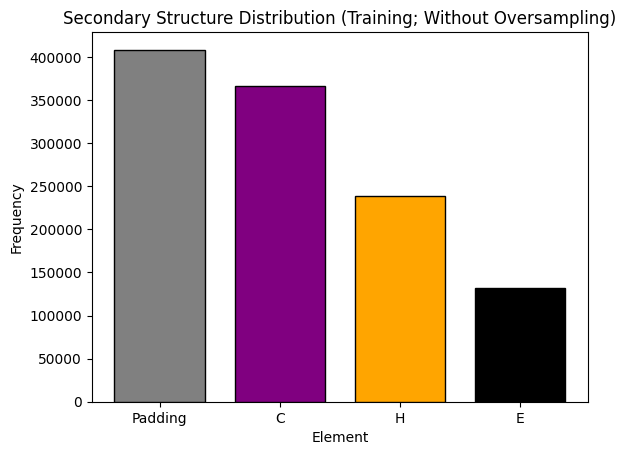

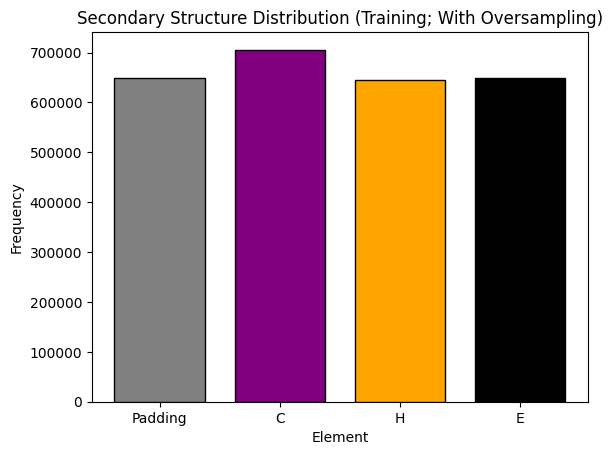

In [15]:
# Define elements for SST-3 and SST-8, and custom colours
ss_types = list(set(np.ravel(y_train)))
labels = ["Padding", "C", "H", "E"]
ss_colours = ["grey", "purple", "orange", "black"]

# Plot for training set distribution before oversampling
sst_visualise(y_train, ss_types, labels, ss_colours, "Secondary Structure Distribution (Training; Without Oversampling)")

# Plot for training set distribution after oversampling
sst_visualise(y_train_new, ss_types, labels, ss_colours, "Secondary Structure Distribution (Training; With Oversampling)")

### Import Classifier and Define Q3 Accuracy Metric

We are interested in using $k$-nearest neighbours for multi-output classification, so we import the relevant functions from scikit-learn. Q3 accuracy is an important metric for assessing the accuracy of our models, as it excludes the padding class in its calculations (it is otherwise equivalent to 'accuracy_score' from scikit-learn).

In [16]:
# Import MultiOutputClassifier and KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

# Create Q3 function using NumPy (accuracy of those other than zero, which is the padding)
def q3_acc_numpy(y_true, y_pred):
    mask = y_true > 0
    q3 = np.equal(np.extract(mask, y_true), np.extract(mask, y_pred)).astype(float)
    return np.sum(q3) / q3.shape[0]

### Investigate Suitable Number of Neighbours

We want to maximise the Q3 accuracy and ensure that our number of neighbours $k$ is not too high and not too low. An odd number of neighbours is typically chosen to ensure that there are no ties between classes. Our range of neighbours to test is [1, 10].

The Euclidean and Manhattan distances are used to determine which provides better results. We assign weights to points based on the inverse of their distance, prioritising closer neighbours with greater influence over those farther away.

#### Without Oversampling

[0.5958786209609993, 0.5958786209609993, 0.587394875325825, 0.5939974425810259, 0.5908252594304825, 0.5911572320857719, 0.5865465007623076, 0.5867678158658338, 0.5837185855505828, 0.5841735110411647]
[0.6041164609255889, 0.6039812128067673, 0.6019647863079722, 0.6052353317267496, 0.604891063787931, 0.6015344513844489, 0.5988171937244873, 0.5974278266856834, 0.5947474548763094, 0.5938007180445581]


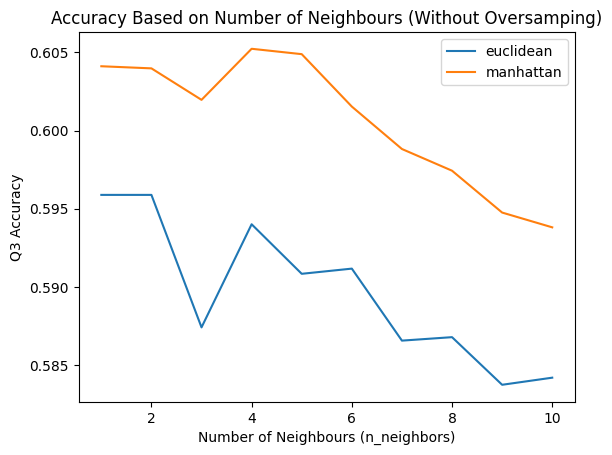

CPU times: user 21min 17s, sys: 6min, total: 27min 17s
Wall time: 19min 13s


In [17]:
%%time

# Without Oversampling

metrics = ["euclidean", "manhattan"]

# Loop over the two metrics
for metric_ in metrics:
    accuracy_data = []
    nums = []
    
    # Loop over every number of neighbours
    for i in range(1, 11):
        # Define model
        knn_model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = i, metric = metric_, weights = "distance"))
        # Fit training set to model
        knn_model.fit(X_train, y_train)
        # Use model to predict the validation set classes (elements)
        y_pred = knn_model.predict(X_val)
        # Calculate Q3 accuracy of prediction and append to 'accuracy_data'
        accuracy = q3_acc_numpy(y_val.flatten(), y_pred.flatten())
        accuracy_data.append(accuracy)
        nums.append(i)

    print(accuracy_data)

    plt.plot(nums, accuracy_data, label = metric_)
    
plt.title("Accuracy Based on Number of Neighbours (Without Oversamping)")
plt.xlabel("Number of Neighbours (n_neighbors)")
plt.ylabel("Q3 Accuracy")
plt.legend()
plt.savefig("no_oversamp_knn.pdf")
plt.show()

#### With Oversampling

[0.5958786209609993, 0.5958786209609993, 0.5860300988540795, 0.5921162642010525, 0.5875670092952343, 0.5879235725175822, 0.5827226675847145, 0.5837185855505828, 0.5814193675306153, 0.5824521713470713]
[0.6039812128067673, 0.6039812128067673, 0.6002311513303497, 0.602985294840899, 0.6018418334726798, 0.5976983229233266, 0.5945261397727831, 0.593849899178675, 0.5922146264692864, 0.5904686962081346]


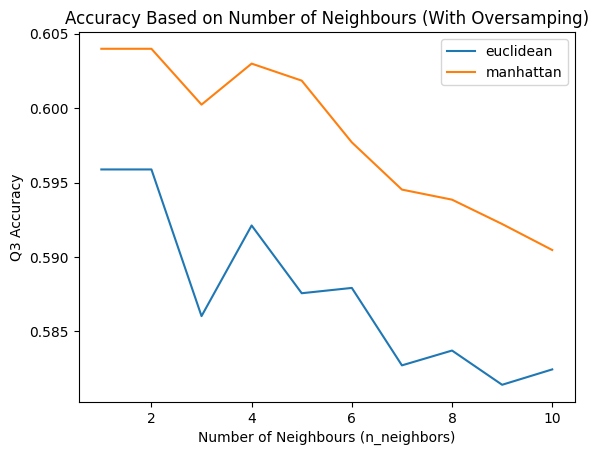

CPU times: user 55min 26s, sys: 7min 23s, total: 1h 2min 49s
Wall time: 51min 49s


In [18]:
%%time

# With Oversampling

metrics = ["euclidean", "manhattan"]

# Loop over the two metrics
for metric_ in metrics:
    accuracy_data = []
    nums = []
    
    # Loop over every number of neighbours
    for i in range(1, 11):
        # Define model
        knn_model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = i, metric = metric_, weights = "distance"))
        # Fit training set to model
        knn_model.fit(X_train_new, y_train_new)
        # Use model to predict the validation set classes (elements)
        y_pred = knn_model.predict(X_val)
        # Calculate Q3 accuracy of prediction and append to 'accuracy_data'
        accuracy = q3_acc_numpy(y_val.flatten(), y_pred.flatten())
        accuracy_data.append(accuracy)
        nums.append(i)

    print(accuracy_data)

    plt.plot(nums, accuracy_data, label = metric_)
    
plt.title("Accuracy Based on Number of Neighbours (With Oversamping)")
plt.xlabel("Number of Neighbours (n_neighbors)")
plt.ylabel("Q3 Accuracy")
plt.legend()
plt.savefig("oversamp_knn.pdf")  
plt.show()

### Set Hyperparameters

In [19]:
# Number of neighbours, distance metric and weight choice

num_neighbours = 5
d_metric = "manhattan"
weight_c = "distance"

### $k$-Fold Cross-Validation (Oversampled Data)

We perform $k$-fold cross-validation on our oversampled data to determine if the accuracy is approximately equal for different subsets of the data.

In [20]:
%%time

# k-Fold Cross-Validation

from sklearn.model_selection import KFold

# Define model based on hyperparameters

knn_model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = num_neighbours, metric = d_metric, weights = weight_c))

# Define 5-fold class

kf = KFold(n_splits = 5, shuffle = True, random_state = randomer)
fold = 1

# Start 5-fold CV, using oversampled data

for train_i, validate_i in kf.split(X_train_new, y_train_new):
    # Fit training subset to model
    knn_model.fit(X_train_new[train_i], y_train_new[train_i])
    # Define validation subset
    y_tester = y_train_new[validate_i]
    # Use model to predict validation subset
    y_preder = knn_model.predict(X_train_new[validate_i])
    # Output fold number and relevant statistics, including accuracy
    print(f"Fold #{fold}, Training Size: {len(X_train_new[train_i])}, Validation Size: {len(X_train_new[validate_i])}")
    print(f"Q3 Accuracy: {round(q3_acc_numpy(y_tester.flatten(), y_preder.flatten()), 4)}")
    # Move to next fold
    fold += 1

Fold #1, Training Size: 21204, Validation Size: 5301
Q3 Accuracy: 0.8508
Fold #2, Training Size: 21204, Validation Size: 5301
Q3 Accuracy: 0.8514
Fold #3, Training Size: 21204, Validation Size: 5301
Q3 Accuracy: 0.8569
Fold #4, Training Size: 21204, Validation Size: 5301
Q3 Accuracy: 0.8485
Fold #5, Training Size: 21204, Validation Size: 5301
Q3 Accuracy: 0.8492
CPU times: user 1h 4min 57s, sys: 1min 17s, total: 1h 6min 15s
Wall time: 1h 6min 16s


### Results of Chosen Model (With Oversampling vs Without Oversampling)

We train our final chosen model and test it on our test set. We also compare the results between training on the oversampled data against training on the original data.

In [21]:
%%time

# We determine that the following is a suitable model based on the above (with and without oversampling), using hyperparameters

# Original Data Model

knn_model1 = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = num_neighbours, metric = d_metric, weights = weight_c))
knn_model1.fit(X_train, y_train)
y_pred1 = knn_model1.predict(X_test)

# Oversampled Data Model

knn_model2 = MultiOutputClassifier(KNeighborsClassifier(n_neighbors = num_neighbours, metric = d_metric, weights = weight_c))
knn_model2.fit(X_train_new, y_train_new)
y_pred2 = knn_model2.predict(X_test)

CPU times: user 11min 34s, sys: 13.3 s, total: 11min 48s
Wall time: 11min 48s


===== Without Oversampling =====

Default Accuracy: 0.7376630007855459
Q3 Accuracy: 0.5965569137026026

               precision    recall  f1-score   support

     Padding   0.891004  0.990729  0.938224     91142
           C   0.664035  0.668637  0.666328     80377
           H   0.618014  0.552076  0.583187     53940
           E   0.579584  0.480080  0.525160     29141

    accuracy                       0.737663    254600
   macro avg   0.688159  0.672880  0.678225    254600
weighted avg   0.725869  0.737663  0.729889    254600



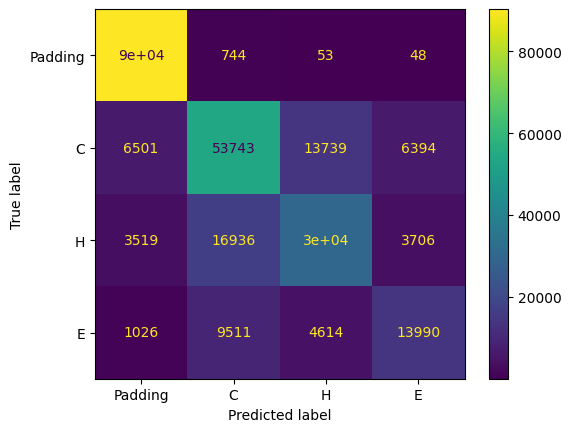

In [22]:
# Class labels as a dictionary, {0: "Padding", 1: "C", 2: "H", 3: "E"}

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

print("===== Without Oversampling =====\n")

# Output useful metrics

print(f"Default Accuracy: {accuracy_score(y_test.flatten(), y_pred1.flatten())}")
print(f"Q3 Accuracy: {q3_acc_numpy(y_test.flatten(), y_pred1.flatten())}")
print("\n", classification_report(y_test.flatten(), y_pred1.flatten(), target_names = ["Padding", "C", "H", "E"], digits = 6))

# Create and display confusion matrix

cm1 = confusion_matrix(y_test.flatten(), y_pred1.flatten())
disp1 = ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = ["Padding", "C", "H", "E"])
disp1.plot()
disp1.figure_.savefig("disp1.pdf")
plt.show()

===== With Oversampling =====

Default Accuracy: 0.7354673998428908
Q3 Accuracy: 0.593259430557085

               precision    recall  f1-score   support

     Padding   0.887906  0.990509  0.936406     91142
           C   0.664405  0.661545  0.662972     80377
           H   0.613240  0.552836  0.581474     53940
           E   0.576067  0.479736  0.523507     29141

    accuracy                       0.735467    254600
   macro avg   0.685405  0.671157  0.676090    254600
weighted avg   0.723463  0.735467  0.727627    254600



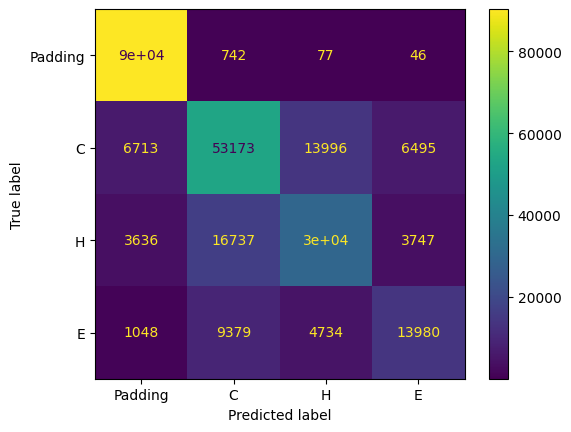

In [23]:
# Class labels as a dictionary, {0: "Padding", 1: "C", 2: "H", 3: "E"}

print("===== With Oversampling =====\n")

# Output useful metrics

print(f"Default Accuracy: {accuracy_score(y_test.flatten(), y_pred2.flatten())}")
print(f"Q3 Accuracy: {q3_acc_numpy(y_test.flatten(), y_pred2.flatten())}")
print("\n", classification_report(y_test.flatten(), y_pred2.flatten(), target_names = ["Padding", "C", "H", "E"], digits = 6))

# Create and display confusion matrix

cm2 = confusion_matrix(y_test.flatten(), y_pred2.flatten())
disp2 = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ["Padding", "C", "H", "E"])
disp2.plot()
disp2.figure_.savefig("disp2.pdf")
plt.show()